In [1]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys
import requests
sys.path.append("..")
from src.audio.utils import plot_waveform

In [2]:
sys.path.append("..")

In [3]:
from src.audio.utils import audio_stats

In [95]:
full_word = "../data/pronunciation/pronunciation_full.wav"

In [96]:
audio, sr_1 = sf.read(full_word)
audio,sr_1

(array([0., 0., 0., ..., 0., 0., 0.], shape=(48811,)), 16000)

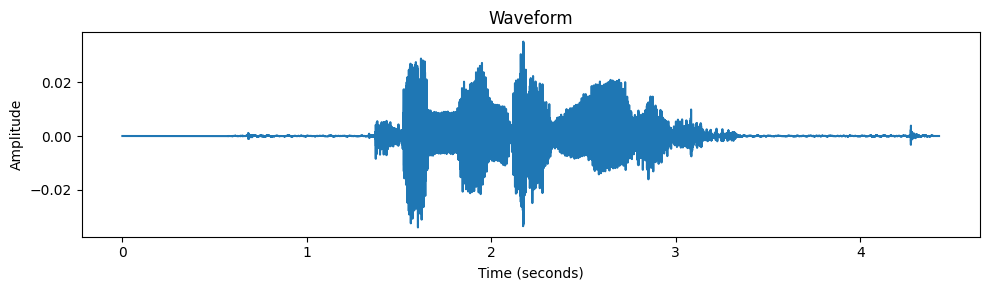

In [97]:
plot_waveform(audio,sr)

In [98]:
audio_trim, _ = librosa.effects.trim(audio, top_db=30)

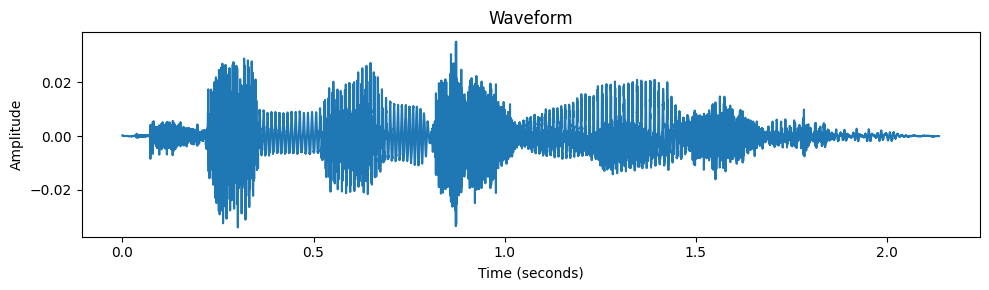

In [99]:
plot_waveform(audio_trim,sr)

In [7]:
MW_LEARNER_API_KEY = os.environ.get("MW_LEARNER_API_KEY")

In [11]:
word = "pronunciation"

url = f"https://www.dictionaryapi.com/api/v3/references/learners/json/{word}"
params = {
    "key": MW_LEARNER_API_KEY
}

In [12]:
#response = requests.get(url, params=params)
response.status_code

200

In [13]:
data = response.json()

In [33]:
data[0].get("hwi").get('prs',[])[0].get('sound').get('audio')

'pronun03'

In [37]:
import requests

output_path = "pronunciation_mw.wav"

resp = requests.get("https://media.merriam-webster.com/audio/prons/en/us/wav/p/pronun03.wav")

if resp.status_code != 200:
    raise RuntimeError(f"Failed to download audio: {resp.status_code}")

# with open(output_path, "wb") as f:
#     f.write(resp.content)

# output_path

In [39]:
headers = {"User-Agent": "Mozilla/5.0"}
output_path = "pronunciation_mw.wav"

with requests.get("https://media.merriam-webster.com/audio/prons/en/us/wav/p/pronun03.wav", headers=headers, stream=True) as r:
    r.raise_for_status()
    with open(output_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 64):
            if chunk:
                f.write(chunk)

print("saved:", output_path)

saved: pronunciation_mw.wav


In [40]:
os.path.getsize(output_path)

12155

In [41]:
print("status:", resp.status_code)
print("content-type:", resp.headers.get("Content-Type"))
print("content-length:", resp.headers.get("Content-Length"))
print("bytes:", len(resp.content))
print("first 80 bytes:", resp.content[:80])

status: 200
content-type: audio/x-wav
content-length: 12155
bytes: 12155
first 80 bytes: b'RIFFs/\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x11+\x00\x00\x11+\x00\x00\x01\x00\x08\x00dataO/\x00\x00\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80'


In [42]:
import os, requests

url = "https://media.merriam-webster.com/audio/prons/en/us/wav/p/pronun03.wav"
headers = {"User-Agent": "Mozilla/5.0"}
output_path = "pronunciation_mw.wav"

resp = requests.get(url, headers=headers)
print("status:", resp.status_code)
print("content-type:", resp.headers.get("Content-Type"))
print("bytes:", len(resp.content))

resp.raise_for_status()

with open(output_path, "wb") as f:
    f.write(resp.content)

print("saved_to:", os.path.abspath(output_path))
print("file_size_on_disk:", os.path.getsize(output_path))

status: 200
content-type: audio/x-wav
bytes: 12155
saved_to: C:\Users\antho\Desktop\pronunciation-coach\notebooks\pronunciation_mw.wav
file_size_on_disk: 12155


In [110]:
audio,sr_2 = sf.read("../data/pronunciation/pronunciation_mw_16k.wav")

In [111]:
sr_2

16000

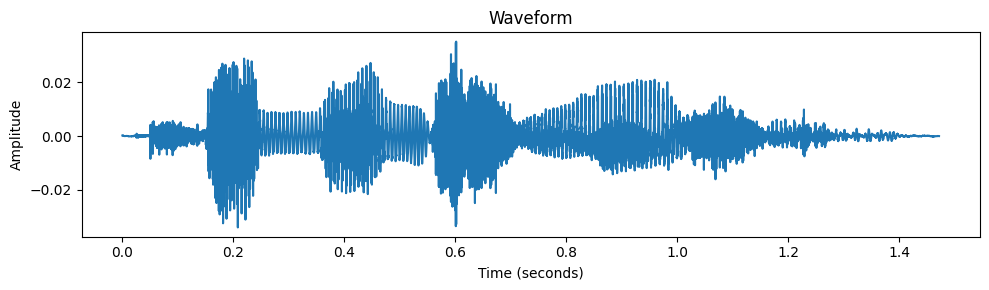

In [112]:
plot_waveform(audio_trim,sr_1)

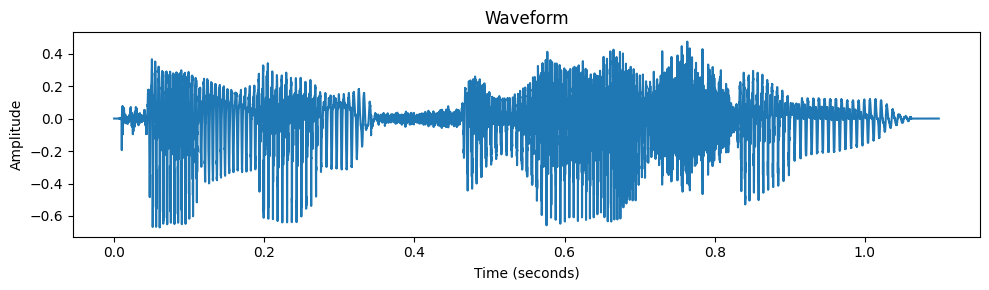

In [113]:
plot_waveform(audio,sr_2)

In [114]:
def stats(x, sr, name):
    x = x.astype(np.float32)
    dur = len(x) / sr
    peak = float(np.max(np.abs(x)))
    rms = float(np.sqrt(np.mean(x**2)))
    print(f"{name}: sr={sr}, seconds={dur:.3f}, peak={peak:.3f}, rms={rms:.3f}")

stats(audio_trim, sr_1, "MY full")
stats(audio, sr_2, "MW baseline")

MY full: sr=16000, seconds=1.472, peak=0.035, rms=0.006
MW baseline: sr=16000, seconds=1.099, peak=0.670, rms=0.151


In [115]:
# mw_16k = librosa.resample(audio.astype("float32"), orig_sr=sr_2, target_sr=16000)

# sf.write("../data/pronunciation/pronunciation_mw_16k.wav", mw_16k, 16000)

In [116]:
my = audio_trim
mw_16k = audio

In [117]:
def rms(x):
    return np.sqrt(np.mean(x**2))

# ensure float32
my_f = my.astype("float32")
mw_f = mw_16k.astype("float32")

rms_my = rms(my_f)
rms_mw = rms(mw_f)

print("Before:")
print("MY  rms:", rms_my)
print("MW  rms:", rms_mw)

# scale MW to match MY loudness
scale = rms_my / (rms_mw + 1e-9)
mw_norm = mw_f * scale

print("\nAfter:")
print("MY  rms:", rms(my_f))
print("MW  rms:", rms(mw_norm))

Before:
MY  rms: 0.006038658
MW  rms: 0.15053472

After:
MY  rms: 0.006038658
MW  rms: 0.006038658


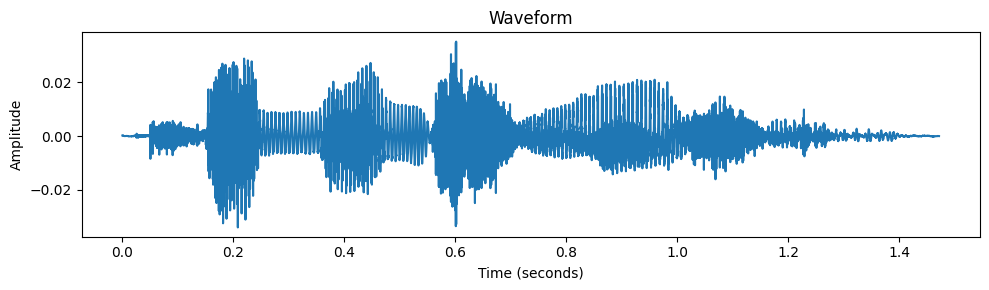

In [118]:
plot_waveform(my_f,sr_2)

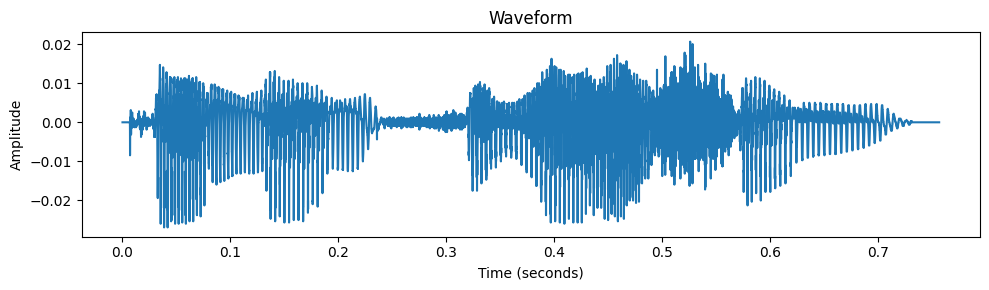

In [119]:
plot_waveform(mw_norm_trim,sr_2)

In [120]:
mw_norm_trim,_ = librosa.effects.trim(mw_norm, top_db=30)

In [121]:
FRAME_MS = 25    # window size
HOP_MS   = 10    # step size

frame_len = int(FRAME_MS * 16000 / 1000)
hop_len   = int(HOP_MS   * 16000 / 1000)

def rms_envelope(x):
    return librosa.feature.rms(
        y=x,
        frame_length=frame_len,
        hop_length=hop_len,
        center=True
    )[0]

my_env = rms_envelope(my_f)
mw_env = rms_envelope(mw_norm_trim)

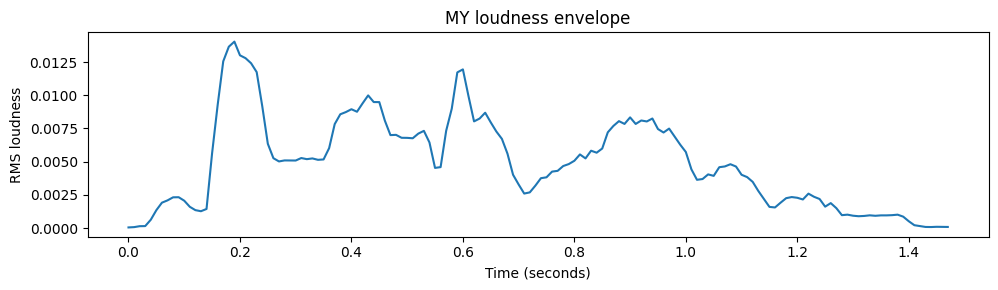

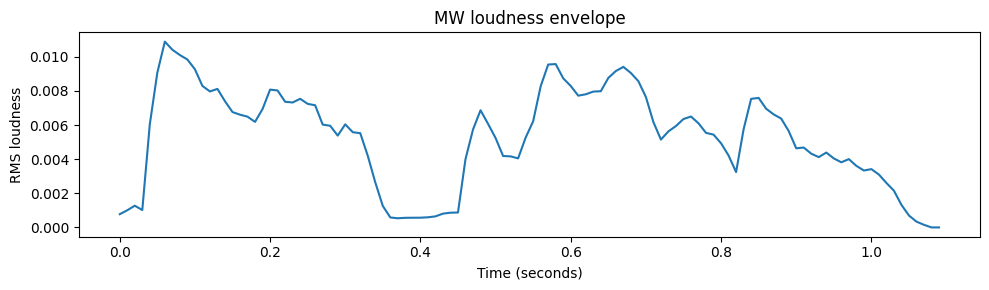

In [122]:
def plot_env(env, title):
    t = np.arange(len(env)) * hop_len / 16000
    plt.figure(figsize=(10,3))
    plt.plot(t, env)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("RMS loudness")
    plt.tight_layout()
    plt.show()

plot_env(my_env, "MY loudness envelope")
plot_env(mw_env, "MW loudness envelope")

In [123]:
from scipy.signal import find_peaks

def detect_peaks(env, hop_len, sr=16000, min_sep_ms=80, prom_frac=0.08):
    """
    env: 1D loudness envelope (RMS)
    min_sep_ms: minimum time separation between peaks (avoid double-peaks)
    prom_frac: peak prominence threshold as fraction of max(env)
    """
    min_sep_frames = int((min_sep_ms / 1000) * sr / hop_len)  # ms -> seconds -> samples -> frames
    prom = prom_frac * float(np.max(env))

    peaks, props = find_peaks(env, distance=min_sep_frames, prominence=prom)
    return peaks, props

my_peaks, my_props = detect_peaks(my_env, hop_len)
mw_peaks, mw_props = detect_peaks(mw_env, hop_len)

print("MY peak frames:", my_peaks)
print("MW peak frames:", mw_peaks)

MY peak frames: [ 19  43  60  90 108]
MW peak frames: [ 6 20 48 58 67 76 85]


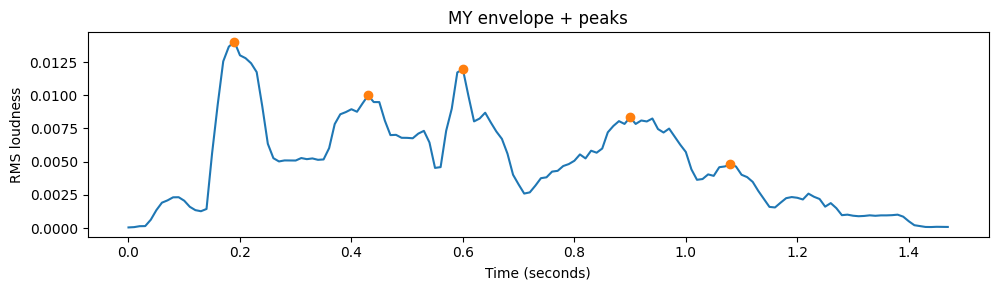

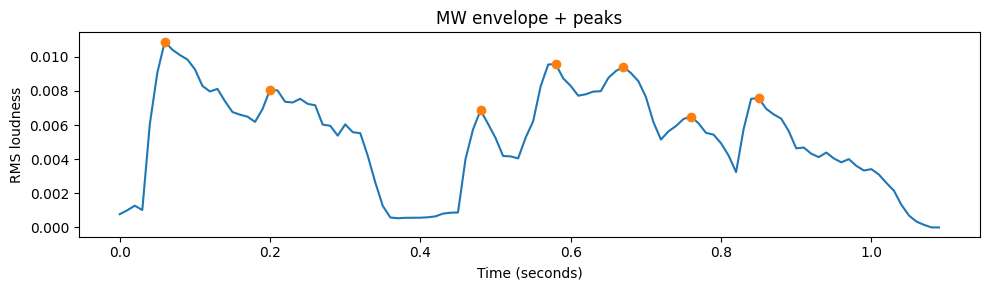

In [124]:
def plot_env_with_peaks(env, peaks, title):
    t = np.arange(len(env)) * hop_len / 16000
    plt.figure(figsize=(10,3))
    plt.plot(t, env)
    plt.plot(t[peaks], env[peaks], "o")  # mark peaks
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("RMS loudness")
    plt.tight_layout()
    plt.show()

plot_env_with_peaks(my_env, my_peaks, "MY envelope + peaks")
plot_env_with_peaks(mw_env, mw_peaks, "MW envelope + peaks")

In [125]:
def primary_stress_peak(env, peaks):
    peak_vals = env[peaks]
    i = int(np.argmax(peak_vals))
    return peaks[i], peak_vals[i]

my_stress_i, my_stress_val = primary_stress_peak(my_env, my_peaks)
mw_stress_i, mw_stress_val = primary_stress_peak(mw_env, mw_peaks)

print("MY primary stress frame:", my_stress_i, "value:", my_stress_val)
print("MW primary stress frame:", mw_stress_i, "value:", mw_stress_val)

MY primary stress frame: 19 value: 0.0140344715
MW primary stress frame: 6 value: 0.010887282


In [126]:
print("MY stress time (s):", my_stress_i * hop_len / 16000)
print("MW stress time (s):", mw_stress_i * hop_len / 16000)

MY stress time (s): 0.19
MW stress time (s): 0.06


In [127]:
# primary_stress_position ∈ {early, middle, late}
# peak_time_my = my_stress_i * hop_len / 16000
# peak_time_mw = mw_stress_i * hop_len / 16000

# relative_position = peak_time / total_duration

NameError: name 'peak_time' is not defined

In [128]:
def get_stress_position(env, peaks, peak_vals, t):
    """
    env       : RMS envelope (1D np.array)
    peaks     : indices of detected peaks (np.array)
    peak_vals : envelope values at peaks (np.array)
    t         : time array for env frames (seconds)

    returns: (rel_pos, label)
    """

    # strongest peak
    strongest_peak_idx = peaks[np.argmax(peak_vals)]

    # time of strongest peak
    peak_time = t[strongest_peak_idx]

    # total duration (after trimming & alignment)
    total_duration = t[-1]

    # relative position [0, 1]
    rel_pos = peak_time / total_duration

    # bucket
    if rel_pos < 0.33:
        label = "early"
    elif rel_pos < 0.66:
        label = "middle"
    else:
        label = "late"

    return rel_pos, label

In [129]:
t_mw = np.arange(len(mw_env)) * hop_len / sr
mw_rel_pos, mw_label = get_stress_position(
    env=mw_env,
    peaks=mw_peaks,
    peak_vals=mw_props,
    t=t_mw
)

print("Baseline:", mw_rel_pos, mw_label)

Baseline: 0.055045871559633024 early


In [130]:
t_my = np.arange(len(my_env)) * hop_len / sr
my_rel_pos, my_label = get_stress_position(
    env=my_env,
    peaks=my_peaks,
    peak_vals=my_props,
    t=t_my
)

print("User:", my_rel_pos, my_label)

User: 0.1292517006802721 early


In [131]:
delta = my_rel_pos - mw_rel_pos
delta

np.float64(0.07420582912063908)

In [132]:
def timing_delta_label(delta):
    absd = abs(delta)

    if absd < 0.10:
        return "about the same"
    elif absd < 0.25:
        return "slightly later" if delta > 0 else "slightly earlier"
    else:
        return "much later" if delta > 0 else "much earlier"
print(timing_delta_label(delta))

about the same


In [133]:
def delta_ms(delta_rel, total_duration_sec):
    """
    delta_rel: user_rel_pos - baseline_rel_pos (unitless)
    total_duration_sec: duration of the word (seconds), from your envelope time axis
    """
    return delta_rel * total_duration_sec * 1000.0

total_sec = t_my[-1]          # or use baseline; pick one consistently (user is fine)
ms = delta_ms(delta, total_sec)

print("delta_rel:", delta)
print("delta_ms:", ms)

delta_rel: 0.07420582912063908
delta_ms: 158.3057687906967


In [134]:
t_my

array([0.        , 0.01451247, 0.02902494, 0.04353741, 0.05804989,
       0.07256236, 0.08707483, 0.1015873 , 0.11609977, 0.13061224,
       0.14512472, 0.15963719, 0.17414966, 0.18866213, 0.2031746 ,
       0.21768707, 0.23219955, 0.24671202, 0.26122449, 0.27573696,
       0.29024943, 0.3047619 , 0.31927438, 0.33378685, 0.34829932,
       0.36281179, 0.37732426, 0.39183673, 0.40634921, 0.42086168,
       0.43537415, 0.44988662, 0.46439909, 0.47891156, 0.49342404,
       0.50793651, 0.52244898, 0.53696145, 0.55147392, 0.56598639,
       0.58049887, 0.59501134, 0.60952381, 0.62403628, 0.63854875,
       0.65306122, 0.6675737 , 0.68208617, 0.69659864, 0.71111111,
       0.72562358, 0.74013605, 0.75464853, 0.769161  , 0.78367347,
       0.79818594, 0.81269841, 0.82721088, 0.84172336, 0.85623583,
       0.8707483 , 0.88526077, 0.89977324, 0.91428571, 0.92879819,
       0.94331066, 0.95782313, 0.9723356 , 0.98684807, 1.00136054,
       1.01587302, 1.03038549, 1.04489796, 1.05941043, 1.07392